# Code

In [1]:
import pandas as pd
import os
import numpy as np
import sys
from sklearn.model_selection import train_test_split
sys.path.insert(0, '..')
import dataset.train_test_val_utils as utils

In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_pairs_data_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')

In [3]:
df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full.csv')).sample(frac=1).drop_duplicates().reset_index(drop = True)
df_genes = pd.read_csv(os.path.join(processed_files_dir, 'df_genes.csv'))

In [4]:
df = pd.read_csv(os.path.join(processed_files_dir, 'final_df.csv'))

### Stupid train test split 

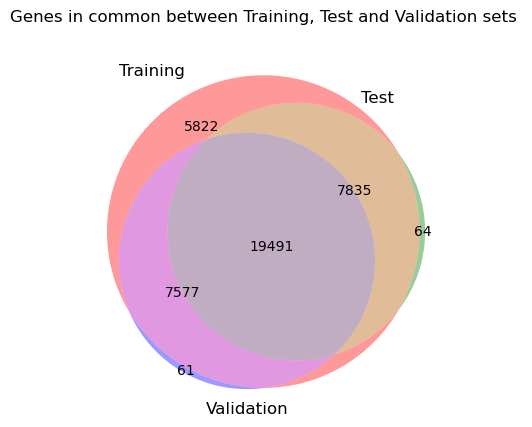

In [5]:
train_val, test = train_test_split(df_pairs_full, test_size=0.15)
train, val = train_test_split(train_val, test_size=0.18)

gene_pairs_training = list(set(train.positive).union(train.negative))
gene_pairs_test = list(set(val.positive).union(val.negative))
gene_pairs_val = list(set(test.positive).union(test.negative))
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

# Proper train test split 

In [6]:
df_pairs_full['gene1'] = df_pairs_full.positive.str.split('_', expand = True)[0]
df_pairs_full['gene2'] = df_pairs_full.positive.str.split('_', expand = True)[1]

df_pairs_full['gene1_neg'] = df_pairs_full.negative.str.split('_', expand = True)[0]
df_pairs_full['gene2_neg'] = df_pairs_full.negative.str.split('_', expand = True)[1]

In [7]:
assert set(df_pairs_full.gene1).union(set(df_pairs_full.gene2)) == set(df_genes.gene_id)
assert set(df_pairs_full.gene1_neg).union(set(df_pairs_full.gene2_neg)) == set(df_genes.gene_id)

In [8]:
#circa 5 min
gene_pairs_training, gene_pairs_test, gene_pairs_val = utils.create_or_load_train_test_val(df_pairs_full, save_path = rna_rna_pairs_data_dir)

Total time: 0.00021986166636149088 minutes


In [11]:
all_possible_pairs = set(df_pairs_full.positive).union(set(df_pairs_full.negative))
assert set(gene_pairs_training).union(set(gene_pairs_val)).union(set(gene_pairs_test)) == all_possible_pairs
assert set(gene_pairs_test).intersection(set(gene_pairs_val)) == set()
assert set(gene_pairs_training).intersection(set(gene_pairs_test)) == set()
assert set(gene_pairs_training).intersection(set(gene_pairs_val)) == set()
# buu = set(gene_pairs_training).intersection(set(gene_pairs_test))
# df_pairs_full[df_pairs_full.negative.isin(buu)]

AssertionError: 

### Plots and stats

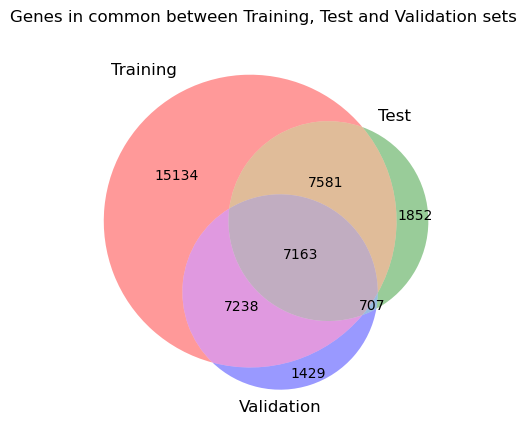

In [10]:
utils.venn_between_genes(gene_pairs_training, gene_pairs_test, gene_pairs_val)

In [12]:
#Percentage of train-test-validation
perc_train = np.round(len(gene_pairs_training)/len(all_possible_pairs), 2)
perc_test = np.round(len(gene_pairs_test)/len(all_possible_pairs), 2)
perc_val = np.round(len(gene_pairs_val)/len(all_possible_pairs), 2)
print(f'{perc_train=}')
print(f'{perc_test=}')
print(f'{perc_val=}')

perc_train=0.72
perc_test=0.14
perc_val=0.14


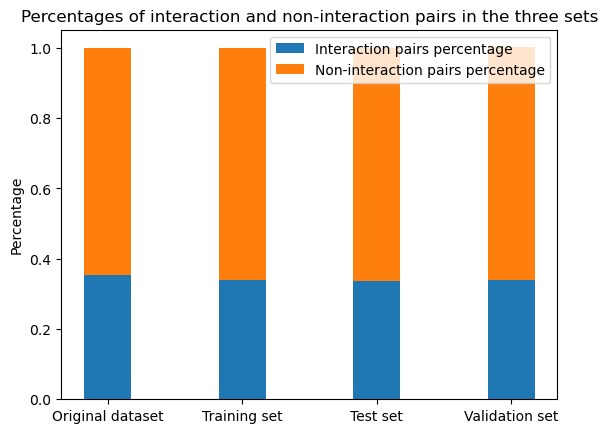

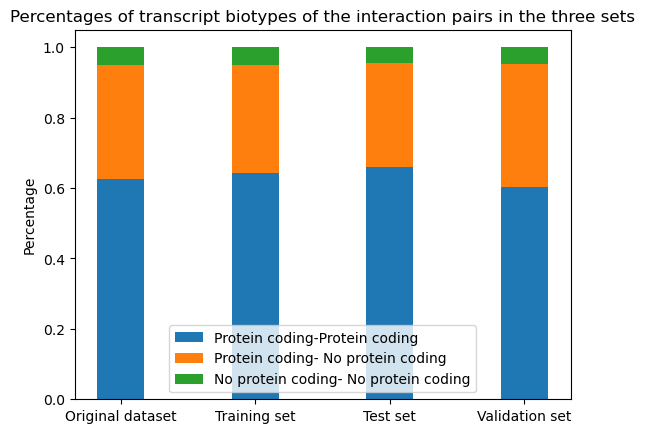

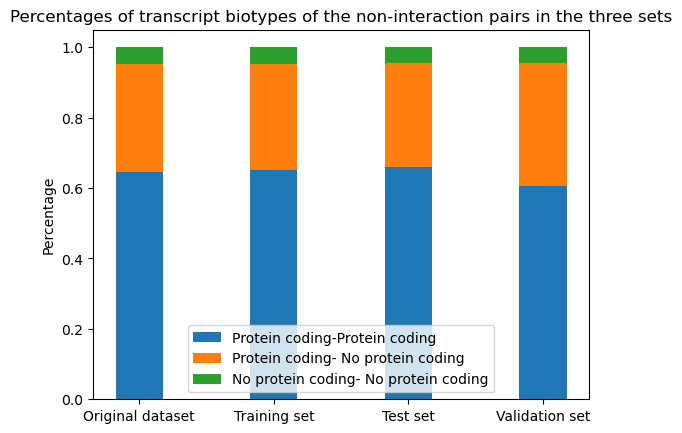

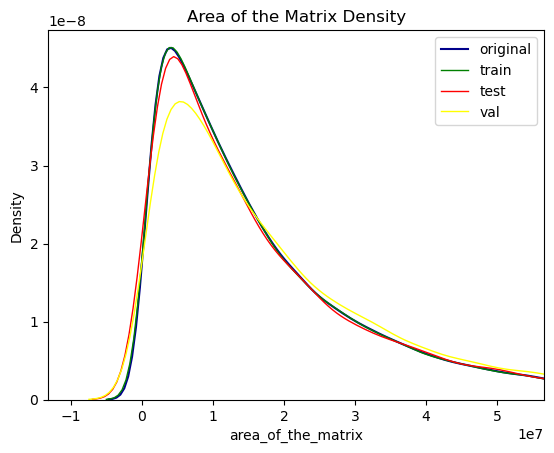

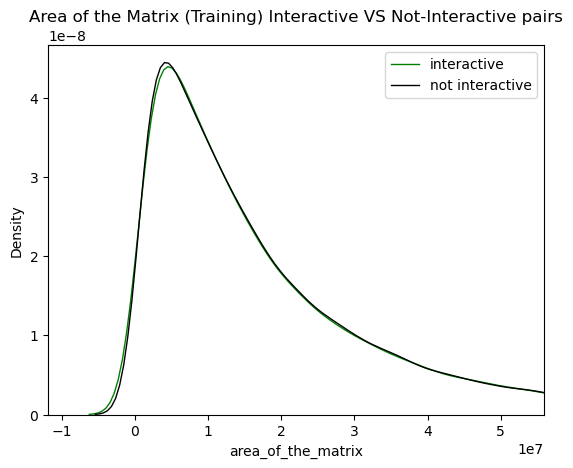

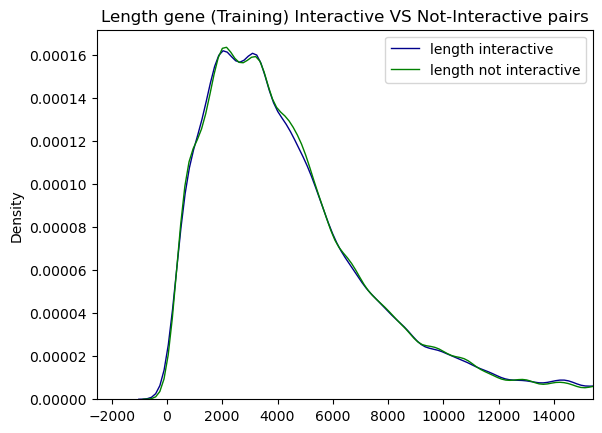

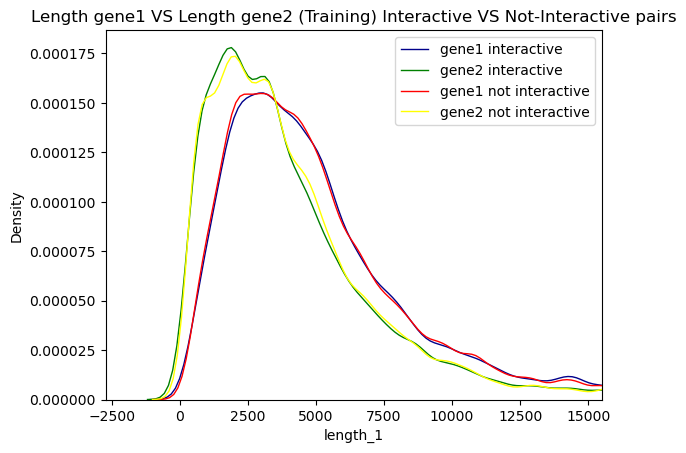

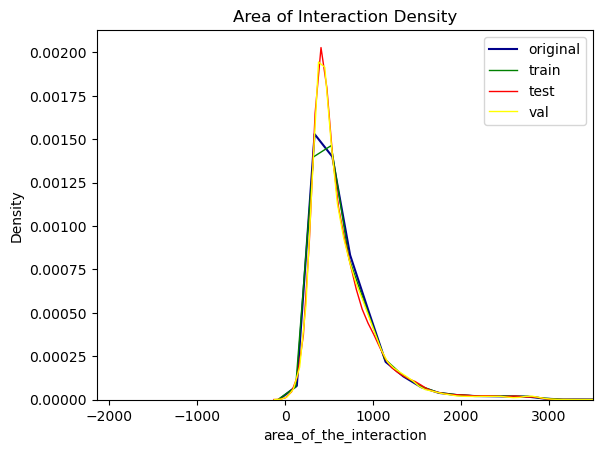

In [13]:
utils.plot_stats(df, gene_pairs_training, gene_pairs_test, gene_pairs_val, limit_plot = 100000000)